# Treat Clinical notes

**COLAB link** https://colab.research.google.com/github/samsung-ai-course/6-7-edition/blob/main/NLP/Computers%20dont%20read%20numbers/clinical_notes.ipynb

In [1]:
# Standard library imports
import os
import re
import requests
import pickle
from tqdm import tqdm

# Data manipulation libraries
import pandas as pd
import numpy as np

# Data visualization libraries
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image

# openAI API library
from openai import OpenAI

# NLTK imports
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

# Download required NLTK data files (run only once)
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

# Read files into a Data Frame

In [2]:
files_list = requests.get("https://raw.githubusercontent.com/samsung-ai-course/6-7-edition/refs/heads/main/NLP/Computers%20dont%20read%20numbers/directories.txt")
files_list  = files_list.text.split("\n")
notes = []
# run this cells only once this can be blocked by github if a lot of runs are tried
for file in tqdm(files_list[:15]):

    note = requests.get("https://raw.githubusercontent.com/samsung-ai-course/6-7-edition/refs/heads/main/NLP/Computers%20dont%20read%20numbers/data/"+file)
    notes.append(note.text)

100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


In [3]:
notes

[" \nName:  ___                  Unit No:   ___\n \nAdmission Date:  ___              Discharge Date:   ___\n \nDate of Birth:  ___             Sex:   F\n \nService: MEDICINE\n \nAllergies: \nCodeine\n \nAttending: ___\n \nChief Complaint:\nI feel shaky\n \nMajor Surgical or Invasive Procedure:\nNone\n \nHistory of Present Illness:\nPt is a ___ year old woman who presents to ED from opthomologists \noffice after she began feeling shaky, nauseous and weak. Blood \nsugar was noted to be 308 and she was sent to the ED. She felt \nnauseous this morning and did not eat breakfast or take her \nmedications, including her insulin. She notes she has been \nfeeling generally weak for the last month and fatigued for about \n6 months. She has been taking prednisone daily since a \nhospitalization in ___ for PNA and new onset AFib. \nAdditionally, she developed sunburn over both feet 5 weeks ago, \nand developed ulcerating blisters for which she has been taking \namoxicillin for the last 5 weeks. S

In [4]:
# Here everything is done dont worry
# replacement of None Values Exercise
def replace_placeholders(text, placeholder="___", replacement="None"):
    return text.replace(placeholder, replacement)

# Extracting key information using regex
def extract_information(text):
    info = {}
    patterns = {
        "Name": r"Name:\s+(.*?)\s+Unit No",
        "Unit No": r"Unit No:\s+(.*?)\n",
        "Admission Date": r"Admission Date:\s+(.*?)\s+Discharge Date",
        "Discharge Date": r"Discharge Date:\s+(.*?)\n",
        "Date of Birth": r"Date of Birth:\s+(.*?)\s+Sex",
        "Sex": r"Sex:\s+(\w)",
        "Service": r"Service:\s+(.*?)\n",
        "Allergies": r"Allergies:\s+(.*?)\n",
        "Chief Complaint": r"Chief Complaint:\n(.*?)\n",
        "Major Surgical or Invasive Procedure": r"Major Surgical or Invasive Procedure:\n(.*?)\n",
        "History of Present Illness": r"History of Present Illness:\n(.*?)\n\n",
        "Review of systems": r"Review of systems:\s+(.*?)\n\n",
        "Past Medical History": r"Past Medical History:\n(.*?)\n\n",
        "Social History": r"Social History:\n(.*?)\n",
        "Family History": r"Family History:\n(.*?)\n\n",
        "Physical Exam": r"Physical Exam:\n(.*?)\n\n",
        "Brief Hospital Course": r"Brief Hospital Course:\n(.*?)\n\n",
        "Discharge Diagnosis": r"Discharge Diagnosis:\n(.*?)\n\n",
        "Discharge Condition": r"Discharge Condition:\n(.*?)\n\n",
        "Discharge Instructions": r"Discharge Instructions:\n(.*?)\n\n",
    }

    for key, pattern in patterns.items():
        match = re.search(pattern, text, re.DOTALL)
        info[key] = match.group(1).strip() if match else "None"

    return info
def structure_data(clinical_text):
    # Replace placeholders in the clinical text
    processed_text = replace_placeholders(clinical_text)

    # Extract information into a dictionary
    return extract_information(processed_text)

structure_notes = [ structure_data(note) for note in notes]


# Null values treatment

In [5]:
df = pd.DataFrame(structure_notes).replace('None',np.NaN)
df.head(3)

<ipython-input-5-6b87928251e2>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = pd.DataFrame(structure_notes).replace('None',np.NaN)


,Name,Unit No,Admission Date,Discharge Date,Date of Birth,Sex,Service,Allergies,Chief Complaint,Major Surgical or Invasive Procedure,History of Present Illness,Review of systems,Past Medical History,Social History,Family History,Physical Exam,Brief Hospital Course,Discharge Diagnosis,Discharge Condition,Discharge Instructions
0,NaN,NaN,NaN,NaN,NaN,F,MEDICINE,Codeine,I feel shaky,NaN,Pt is a None year old woman who presents to ED...,(+) Per HPI. Also notes recent weight gain whi...,"-IDDM c/b retinopathy\n-HTN\n-AFib, diagnosed ...",NaN,"- 6 children, one daughter died last year from...",FEX ON ADMISSION\nVitals: T: 98.4 BP: 176/96 P...,None year old woman with IDDM and AFib on coum...,Lactic acidosis\nHyperglycemia\nUrinary tract ...,Mental Status: Clear and coherent.\nLevel of C...,"Dear Ms. None,"
1,NaN,NaN,NaN,NaN,NaN,M,MEDICINE,Demerol,Dyspnea,Bronchoscopy,This is an None yo M with history of mild deme...,NaN,gastroesophageal reflux disease\nhypercholeste...,NaN,"strong family history of diabetes mellitus, an...","VS: T 98.6max, 97.3current, BP None, HR 79 RR ...",None year old male with complaints of dyspnea...,Lung mass\nAcute renal failure\nHypoxia,"Stable, for home with services.",You were admitted to the hospital because of y...
2,NaN,NaN,NaN,NaN,NaN,F,ORTHOPAEDICS,No Known Allergies / Adverse Drug Reactions,RLE pain,Right short trochanteric fixation nail,"None, blown over by gust of wind w/R ITFx now ...",NaN,MedHx:\n-HTN\n-Hypercholesterolemia\n-Eczema\n...,NaN,"Mother deceased with HTN, CAD. Father deceased...",NaN,The patient presented to the emergency departm...,right intertrochanteric femur fracture,"AAOx3, mentating appropriately, NVI","Weigh yourself every morning, call MD if weigh..."


In [6]:
df.isnull().sum()

,0
Name,14
Unit No,15
Admission Date,15
Discharge Date,15
Date of Birth,15
Sex,0
Service,0
Allergies,0
Chief Complaint,0
Major Surgical or Invasive Procedure,4


In [7]:
# Drop columns with nan values
df_treated = df.dropna(axis=1)

# Complete yourself

In [8]:
# Lets start building a corpus
discharged_diagnosis = ' '.join(df_treated['Discharge Diagnosis'].to_list())

In [9]:

# Function to clean individual lines
def clean_line(line):
    # Remove HTML-like tags
    line = re.sub(r'<.*?>', '', line)
    # Remove unwanted characters (e.g., non-ASCII characters)
    line = re.sub(r'[^\x00-\x7F]+', '', line)
    # Strip leading/trailing whitespace
    return line.strip()

def speaking_text_cleaner(speaking_text):
    # Process each line to clean it
    cleaned_lines = []
    for line in speaking_text.splitlines():
        cleaned_line = clean_line(line)
        if cleaned_line:  # Only add non-empty lines
            cleaned_lines.append(cleaned_line)
    return "\n".join(cleaned_lines)

cleaned_discharged_diagnosis = speaking_text_cleaner(discharged_diagnosis)

In [10]:
def corpus_cleaner(cleaned_text,n_min = 4 ):
    n_min = 4                                                           # Minimum number of characters.
    corpus = []
    lemmatizer = WordNetLemmatizer()

    pre = re.sub(r'\W', ' ', cleaned_text)                          # Substitute the non-alphanumerics character by space.
                                        # Remove numbers.                                      # Exercise
    pre = nltk.word_tokenize(pre)                                   # Tokenize into words.                                 # Exercise
    pre = [x for x in pre if len(x) > n_min]                        # Minimum length.
    pre = [x.lower() for x in pre]                                  # Convert into the lowercase.
    pre = [x for x in pre if x not in stopwords.words('english')]   # Remove stopwords.
    pre = [lemmatizer.lemmatize(x) for x in pre]                    # Lemmatize.
    corpus += pre                                                   # Back to the corpus.
    return corpus

In [11]:
corpus_clean  = corpus_cleaner( cleaned_discharged_diagnosis )

# Count the words

<Axes: >

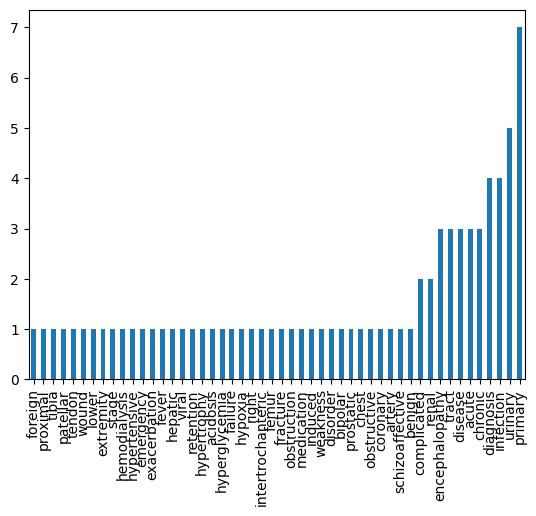

In [17]:
from collections import Counter

# choose words you want to remove
remove_words = ['primary','secondary','going','diagnosis','right']
treated_corpus = [x for x in corpus_clean if x not in remove_words]
pd.Series(Counter(corpus_clean)).sort_values()[-50:].plot(kind='bar')

# Word Cloud

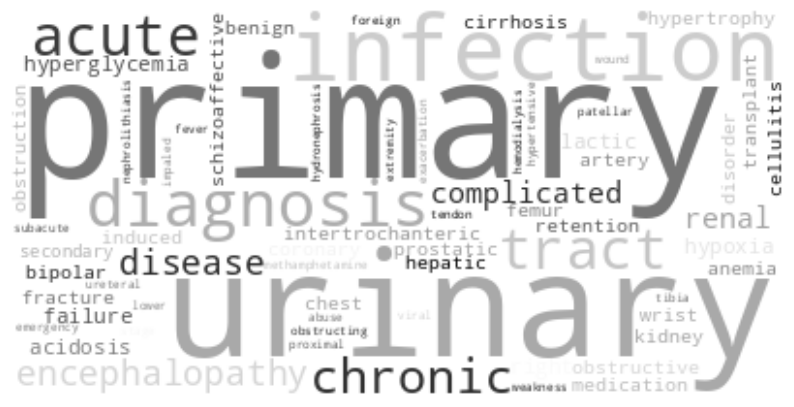

In [18]:
a_long_sentence = ' '.join(corpus_clean)
wc = WordCloud(background_color='white', max_words=70,colormap='gist_gray')                  # Customize the output.
wc.generate(a_long_sentence)
# wc.words_                                                          # Check for the top ranking words.
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")                                    # Turn off the axes.
#plt.savefig('clinical_notes.png',bbox_inches='tight')
plt.show()